# A quest for a new Emoji
__with generative models__

For this laboratory we have one goal, to produce a new emoji using generative models. The idea is to learn from a dataset of emojis and try to create new ones, possibly obtaining something with some semantic meaning. 

What is a good Emoji? 
An emoji where we understand what it's supposed to be

In [ ]:
import keras
import tensorflow as tf
from keras import layers
from keras import ops
import math
import numpy as np
import matplotlib.pyplot as plt
import os
# Set the engine 
os.environ["KERAS_BACKEND"] = "tensorflow"

### The dataset

The full emoji dataset contains most emoji from well known sources, amounting to 14253 images of 72x72 in size. 

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "image", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Let's take a look at some of the images

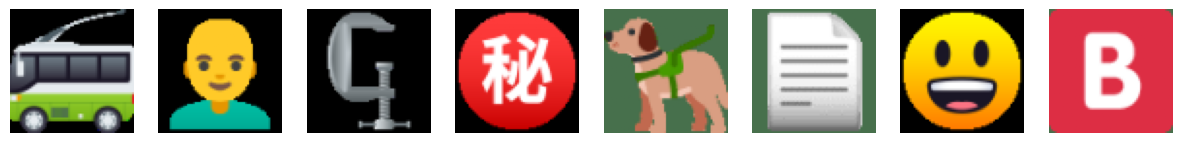

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(15, 5))
for i, x in enumerate(dataset):
    if i >= 8:  # Break the loop after the first 6 images
        break
    ax = axes[i]  # Select the subplot for the current image
    ax.imshow(x[0])
    ax.axis('off')  # Hide axes for cleaner look
plt.show()

The images are resized to 64x64, in 3 channels color. I utilize a tf map dataset to generate the batches. 

In [4]:
#Let's take a look at the shape of one batch
next(iter(dataset)).shape

TensorShape([32, 64, 64, 3])

### Generative Models

Image generative models are a type of artificial intelligence designed to create new images from existing data. They learn the underlying patterns and features of visual data, such as photos or drawings, and can generate new, unique images that are similar in style or content to the training data. 

Generative models have to create __new__ data, defining a training process to evaluate this process is challenging problem. 

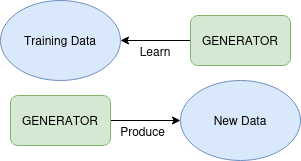

Multiple ways exixts to implement this process, let's focus on the techinque used to enforce the relationship between the training data and the generated data.

- New data has to fool a discriminator trained to differentiate between real and fake images
- Explicitly try to model the training data distribution and sample from it 

You have seen the VAE, which is a possible implementation of generative architecture. Today we will focus on the two main alternatives:

the __GAN__ and the __Diffusion Model__

### The GAN

The GAN is one of the best known neural architectures, and was at the center of image generative models for a long time. The core idea behind gan is to define two separate models, a Generator and a Discriminator, and implement the training prosess as a min-max game between the two. 

__The goal of the discriminator is do effectively classify images in two class, real and fake. Where the real ones are the training data and the fake one are produced by the generator__. 

__The goal of the generator is just to fool the discriminator__

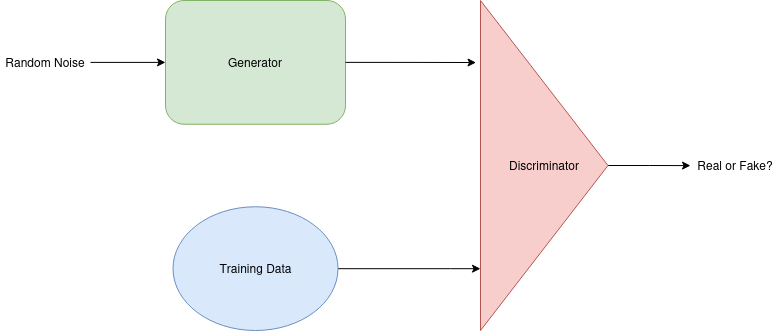

The general idea is quite elegant. As long as both networks keep "competing" the discriminator will be effective at recognizing real and fake images, but more importantly the generator will learn to generate images similar to the training data. The generator can then be used on it's own to generate the necessary images.

Why do I need the discriminator, can't I just train the generator on the training data? 

The definition of the two losses is as expected. The loss of the disciminator is just a classification loss on the two sets of images (real and fake). The generator loss is a bit more complex, the target is a classification loss on the discriminator, measuring how many of the generated images have been classified as "real". 

*Pros of Gans:* 
 - simple to understand
 - high quality results
 - generation is very efficient

*Cons of Gans:*
 - They just never work out of the box :(

Let's implement a simple GAN, starting with a Discriminator. Which is a simple classification network wich convoluted layers, and a dense layer with a sigmoid activation.

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)        │      3,136 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)       │    131,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)         │    262,272 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │      8,193 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

The generator is simmetric. In more complex implementations a U-net like network is usually preferrable.

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)              │  1,056,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)       │    262,272 │
│ (Conv2DTranspose)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)       │    524,544 │
│ (Conv2DTranspose)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)       │  2,097,664 │
│ (Conv2DTranspose)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)         │     38,403 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

We now need to implement the training loop, which is "non standard", we cannot simply call the fit() method...

The are two main ways to implement this process:

1) Rewriting the train step
2) Rewriting the fit method

Can you guess how to do both? 

In [7]:
# Let's rewrite the train step method
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise 
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [8]:
epochs = 50 # at least 100 is better

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy())

In [22]:
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, save_freq=10, save_path='weights_gan/'):
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            gan.generator.save_weights(f'{self.save_path}generator{epoch + 1}.weights.h5')
            gan.discriminator.save_weights(f'{self.save_path}discriminator{epoch + 1}.weights.h5')


In [25]:
history = gan.fit(
    dataset, epochs=epochs, initial_epoch = 0, callbacks=[SaveWeightsCallback()]
)

Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - d_loss: 0.3620 - g_loss: 2.1719
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - d_loss: 0.3589 - g_loss: 1.8297
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3641 - g_loss: 1.8043
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3576 - g_loss: 1.9134
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3506 - g_loss: 2.0008
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3534 - g_loss: 1.8068
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3541 - g_loss: 1.9873
Epoch 8/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3572 - g_loss: 1.8644
Epoch 9/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - d_loss: 0.3487 - g_loss: 2.0319
Epoch 10/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - d_loss: 0.3492 - g_loss: 1.8743
Epoch 11/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - d_loss: 0.3439 - g_loss: 1.9599
Epoch 12/50
446/446 ━━━━━━━━━━

In [10]:
gan.generator.load_weights("150gan.weights.h5")
gan.discriminator.load_weights("150disc.weights.h5")

Very few assumptions can be made on GAN convergence. Experimentally, expects to train for a large amount of epochs. 
Let's take a look at the history of the losses: 

In [20]:
def normalize(a):
    return - (a - a.min()) / (a.min() - a.max())

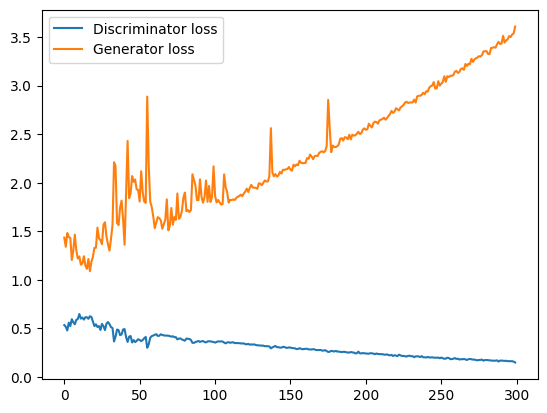

In [22]:
d_loss_history = np.load("d_loss_history.npy")
g_loss_history = np.load("g_loss_history.npy")
plt.plot(d_loss_history,label = "Discriminator loss")
plt.plot(g_loss_history,label = "Generator loss")
# plt.plot(normalize(d_loss_history),label = "Discriminator loss")
# plt.plot(normalize(g_loss_history),label = "Generator loss")
plt.legend()

Evidently, training a GAN is quite unusual. Our goal here is not for the loss to decrease, but actually the optimal situation is the two losses being stable, with the generator and discriminator competing on the same level. 

If one of the model (usually the disciminator) is more skilled than the generator, the training stalls, the gradient is no longer carrying any information and we have the well known situation of __mode collapse__

This inherent fragility makes GAN one of the most complex model to train, lets see some of the most common implementation of GAN:

1) Conditioned GAN: The generator may be conditioned with extra informations to achieve piloted generation
2) Wasserstein GAN:  Introduces a new way to measure the distance between the distribution of generated data and real data, significantly improving the stability of training.
3) Patch GAN: Instead of classifying the whole images we can classify a subset of patches, making the discriminator job more complex
4) SRGAN: Super resolution GAN obtained via the addition of a perceptual loss aided by a VGG style sample
5) Pre-trained generator GAN: Start with a generator slightly pre-trained on the trinaing data, avoid the supremacy of the discriminator

And the list goes on and on... 

We learn from this that GAN, although quite effective is very sensible on the specific application and takes a long time to tune. 

But let's look at some of the results of our GAN: 

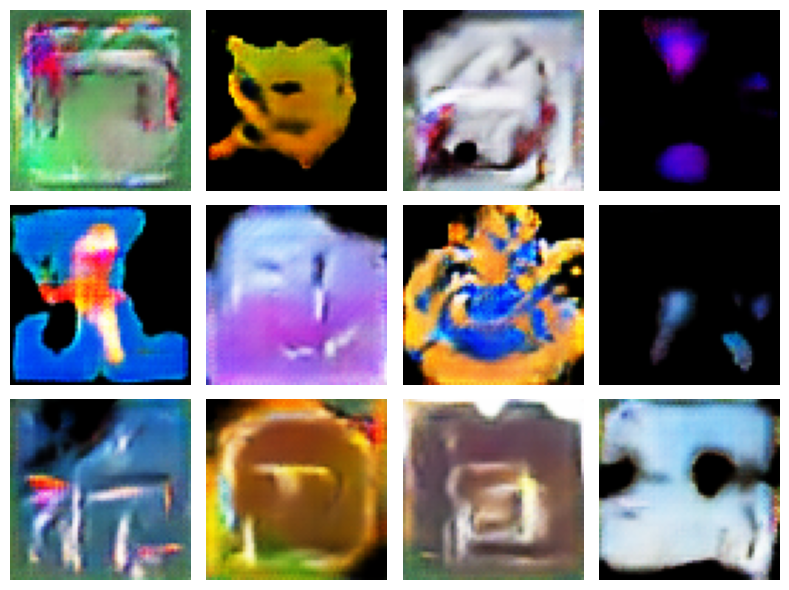

In [12]:
# The generator is fed normal noise, the same way as in train_step
random_latent_vectors = keras.random.normal(shape=(12, 128))
# Generate the images 
generated_images = gan.generator(random_latent_vectors)
output = generated_images.numpy()

# Plot the images 
fig, axs = plt.subplots(3, 4, figsize=(8, 6)) 
axs = axs.ravel() 
for i in range(12):
    axs[i].imshow(output[i])  
    axs[i].axis('off') 
plt.tight_layout() 
plt.show() 

Is it any good? Not really...

### The Diffusion Model

We now look at another generative approach, the diffusion model. The diffusion model is now the most common and most widely used generative model for images. 

You have certainly seen alread images produced by a diffusion model, most commonly the stable diffusion implementation of DALL-E

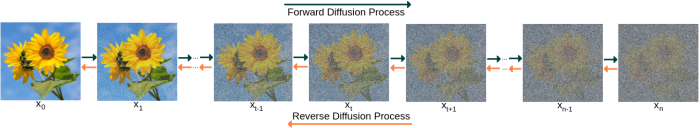

In Practice: 

- Training Phase, a custom amount of noise is added to a training image and a U-net is tasked to denoise it
- Generating Phase, starting from just noise iteratively denoise the image and re-add noise for a fized number of steps

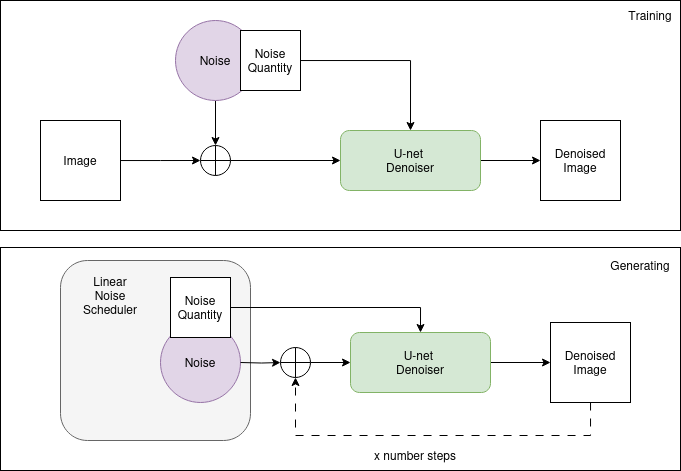

Diffusion model effectively model the training data distribution. The mathematics involved is quite interesting, and a major distinction exists between DDPM and DDIM, but this laboratory is not long enough to get into that. 

Diffusion model are stable and powerful, they are able to match GAN performance without most of the problematics that GAN has to endure in the training phase. 

Let's implement the Diffusion Model:

In [2]:
# data
num_epochs = 80  # train for at least 50 epochs for good results
image_size = 64
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "image", label_mode=None, image_size=(64, 64), batch_size=64
)
dataset = dataset.map(lambda x: x / 255.0)

def filter_batch_by_size(image):
    return tf.shape(image)[0] == 64

# Apply the filter
filtered_dataset = dataset.filter(filter_batch_by_size)

The code for diffusion model is more complex than the GAN, let's explore it:

__denoising U-Net__

In [4]:
# The sinusoidal embeddin gis necessary to encode the amount of noise, necessary to the Unet for the denoising part
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings

# You should be familiar with the residual block 
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

# The down block combines residual with average pooling for downsampling
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

# The Up-Block block combines residual with upsampling2d for the upsampling part
def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

# This function creates the U-net for our purpose, including the conditioning with the noise amount
def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


The Diffusion model class utilize the denoising U-net to implement the diffusion process, including a variety of methods: 

1) train-step,take a batch, add noise, denoise the image and compute the loss on the predicted noise.
2) est-step, the same as train step but no gradient is computed
3) denoise, given an image and noise rate perform the denoise
4) reverse diffusion, given full noise iteratively add noise and denoise it for a fixed number of steps
5) plot images, generate, denormalize: utility functions

In [5]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        #self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation

        network = self.network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

In [6]:
from tensorflow.keras.callbacks import Callback
class SaveModelEveryNEpochs(Callback):
    def __init__(self, save_freq, save_dir='model_saves'):
        super(SaveModelEveryNEpochs, self).__init__()
        self.save_freq = save_freq
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:  # Epochs are zero-indexed, so add 1
            filepath = os.path.join(self.save_dir, f'model_epoch_{epoch+1}.weights.h5')
            self.model.network.save_weights(filepath)
            print(f'Saved model weights to {filepath} at epoch {epoch+1}')

# Usage
save_callback = SaveModelEveryNEpochs(save_freq=10, save_dir='weights_ddim')

In [10]:
model = DiffusionModel(image_size, widths, block_depth)
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(dataset)

In [11]:
history = model.fit(
    filtered_dataset,
    steps_per_epoch = 440,
    epochs=100,
    #validation_data=val_dataset,
    callbacks=[
        #keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        #save_callback,
    ],
)

Epoch 1/100


2024-04-29 22:45:08.352293: I external/local_xla/xla/service/service.cc:168] XLA service 0x2a2d30f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 22:45:08.352313: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-04-29 22:45:08.510542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  2/440 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - i_loss: 2.5240 - n_loss: 0.7981   

I0000 00:00:1714423529.324473    8093 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


440/440 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - i_loss: 0.7321 - n_loss: 0.2964
Epoch 2/100
  1/440 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - i_loss: 0.3441 - n_loss: 0.1577

2024-04-29 22:45:44.453472: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145
/home/faster/anaconda3/envs/keras3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


440/440 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - i_loss: 0.2936 - n_loss: 0.1497
Epoch 3/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - i_loss: 0.2490 - n_loss: 0.1485

2024-04-29 22:45:59.840254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - i_loss: 0.2482 - n_loss: 0.1321
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - i_loss: 0.2369 - n_loss: 0.1229
Epoch 5/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - i_loss: 0.2081 - n_loss: 0.1112

2024-04-29 22:46:30.869575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - i_loss: 0.2256 - n_loss: 0.1150
Epoch 6/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1836 - n_loss: 0.1053

2024-04-29 22:46:46.479422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - i_loss: 0.2169 - n_loss: 0.1099
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - i_loss: 0.2115 - n_loss: 0.1055
Epoch 8/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - i_loss: 0.1796 - n_loss: 0.1015 

2024-04-29 22:47:17.741581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.2024 - n_loss: 0.1044
Epoch 9/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - i_loss: 0.2283 - n_loss: 0.1049 

2024-04-29 22:47:33.449880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1975 - n_loss: 0.1026
Epoch 10/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.2027 - n_loss: 0.0957

2024-04-29 22:47:49.191392: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1987 - n_loss: 0.1010
Epoch 11/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1929 - n_loss: 0.0994
Epoch 12/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1588 - n_loss: 0.1009

2024-04-29 22:48:20.668429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1895 - n_loss: 0.0984
Epoch 13/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1900 - n_loss: 0.0964

2024-04-29 22:48:36.430555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1873 - n_loss: 0.0955
Epoch 14/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - i_loss: 0.1896 - n_loss: 0.0944

2024-04-29 22:48:52.209665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1852 - n_loss: 0.0944
Epoch 15/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1640 - n_loss: 0.0942

2024-04-29 22:49:07.991422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1830 - n_loss: 0.0947
Epoch 16/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1624 - n_loss: 0.0971

2024-04-29 22:49:23.794315: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1793 - n_loss: 0.0932
Epoch 17/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.2031 - n_loss: 0.0904

2024-04-29 22:49:39.607647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1825 - n_loss: 0.0908
Epoch 18/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1790 - n_loss: 0.0918

2024-04-29 22:49:55.435397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1765 - n_loss: 0.0911
Epoch 19/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1591 - n_loss: 0.0917

2024-04-29 22:50:11.258902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1760 - n_loss: 0.0904
Epoch 20/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1778 - n_loss: 0.0897
Epoch 21/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1717 - n_loss: 0.0878 

2024-04-29 22:50:42.899990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1739 - n_loss: 0.0889
Epoch 22/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1863 - n_loss: 0.1004

2024-04-29 22:50:58.753510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1736 - n_loss: 0.0901
Epoch 23/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1743 - n_loss: 0.0883
Epoch 24/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1888 - n_loss: 0.0778

2024-04-29 22:51:30.443978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1723 - n_loss: 0.0867
Epoch 25/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1756 - n_loss: 0.0929 

2024-04-29 22:51:46.310782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1690 - n_loss: 0.0874
Epoch 26/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1456 - n_loss: 0.0871 

2024-04-29 22:52:02.182742: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1683 - n_loss: 0.0872
Epoch 27/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1709 - n_loss: 0.0853
Epoch 28/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1608 - n_loss: 0.0853

2024-04-29 22:52:33.953046: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1662 - n_loss: 0.0857
Epoch 29/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.2310 - n_loss: 0.0816

2024-04-29 22:52:49.836251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1692 - n_loss: 0.0861
Epoch 30/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1684 - n_loss: 0.0850
Epoch 31/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1644 - n_loss: 0.0843
Epoch 32/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1736 - n_loss: 0.0797

2024-04-29 22:53:37.492330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1641 - n_loss: 0.0845
Epoch 33/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1769 - n_loss: 0.0849 

2024-04-29 22:53:53.378064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1633 - n_loss: 0.0832
Epoch 34/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1663 - n_loss: 0.0831
Epoch 35/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1799 - n_loss: 0.0801

2024-04-29 22:54:25.150267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1621 - n_loss: 0.0832
Epoch 36/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1458 - n_loss: 0.0855

2024-04-29 22:54:41.018211: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1613 - n_loss: 0.0837
Epoch 37/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1405 - n_loss: 0.0886

2024-04-29 22:54:56.868876: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1659 - n_loss: 0.0824
Epoch 38/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1486 - n_loss: 0.0777

2024-04-29 22:55:12.702589: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1598 - n_loss: 0.0822
Epoch 39/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1613 - n_loss: 0.0829
Epoch 40/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1553 - n_loss: 0.0826

2024-04-29 22:55:44.356803: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1620 - n_loss: 0.0808
Epoch 41/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1483 - n_loss: 0.0848

2024-04-29 22:56:00.187002: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1585 - n_loss: 0.0811
Epoch 42/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1570 - n_loss: 0.0767

2024-04-29 22:56:16.024154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1596 - n_loss: 0.0815
Epoch 43/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1824 - n_loss: 0.0775

2024-04-29 22:56:31.856143: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1600 - n_loss: 0.0811
Epoch 44/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1602 - n_loss: 0.0801
Epoch 45/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1852 - n_loss: 0.0749 

2024-04-29 22:57:03.524174: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1570 - n_loss: 0.0804
Epoch 46/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1441 - n_loss: 0.0773

2024-04-29 22:57:19.373546: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1562 - n_loss: 0.0809
Epoch 47/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1515 - n_loss: 0.0825

2024-04-29 22:57:35.213236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1611 - n_loss: 0.0797
Epoch 48/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1806 - n_loss: 0.0742

2024-04-29 22:57:51.036270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1564 - n_loss: 0.0797
Epoch 49/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1564 - n_loss: 0.0807
Epoch 50/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1274 - n_loss: 0.0835

2024-04-29 22:58:22.707156: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1586 - n_loss: 0.0790
Epoch 51/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1639 - n_loss: 0.0756

2024-04-29 22:58:38.523970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1557 - n_loss: 0.0791
Epoch 52/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1535 - n_loss: 0.0792
Epoch 53/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1387 - n_loss: 0.0758

2024-04-29 22:59:10.183342: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1570 - n_loss: 0.0795
Epoch 54/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1379 - n_loss: 0.0792 

2024-04-29 22:59:26.007220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1569 - n_loss: 0.0778
Epoch 55/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1532 - n_loss: 0.0848

2024-04-29 22:59:41.845173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1528 - n_loss: 0.0783
Epoch 56/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1542 - n_loss: 0.0710

2024-04-29 22:59:57.677706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1528 - n_loss: 0.0786
Epoch 57/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1589 - n_loss: 0.0837

2024-04-29 23:00:13.504548: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1562 - n_loss: 0.0777
Epoch 58/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1622 - n_loss: 0.0754

2024-04-29 23:00:29.346763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1537 - n_loss: 0.0778
Epoch 59/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1717 - n_loss: 0.0754 

2024-04-29 23:00:45.159387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1555 - n_loss: 0.0786
Epoch 60/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1653 - n_loss: 0.0811

2024-04-29 23:01:01.006994: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1551 - n_loss: 0.0776
Epoch 61/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1426 - n_loss: 0.0795

2024-04-29 23:01:16.847258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1538 - n_loss: 0.0775
Epoch 62/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1501 - n_loss: 0.0763

2024-04-29 23:01:32.680761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1527 - n_loss: 0.0784
Epoch 63/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1564 - n_loss: 0.0797 

2024-04-29 23:01:48.515290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1542 - n_loss: 0.0780
Epoch 64/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1547 - n_loss: 0.0816

2024-04-29 23:02:04.373974: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1552 - n_loss: 0.0769
Epoch 65/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1400 - n_loss: 0.0743

2024-04-29 23:02:20.220793: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1506 - n_loss: 0.0768
Epoch 66/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - i_loss: 0.1375 - n_loss: 0.0765

2024-04-29 23:02:36.076294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1514 - n_loss: 0.0772
Epoch 67/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1469 - n_loss: 0.0747

2024-04-29 23:02:51.926115: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1525 - n_loss: 0.0760
Epoch 68/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - i_loss: 0.1517 - n_loss: 0.0783

2024-04-29 23:03:07.760960: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1503 - n_loss: 0.0766
Epoch 69/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1544 - n_loss: 0.0767

2024-04-29 23:03:23.598490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1516 - n_loss: 0.0773
Epoch 70/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1432 - n_loss: 0.0765

2024-04-29 23:03:39.425761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1533 - n_loss: 0.0763
Epoch 71/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1356 - n_loss: 0.0762

2024-04-29 23:03:55.262807: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1504 - n_loss: 0.0758
Epoch 72/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1497 - n_loss: 0.0808 

2024-04-29 23:04:11.101783: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1500 - n_loss: 0.0763
Epoch 73/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1676 - n_loss: 0.0729

2024-04-29 23:04:26.964751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1493 - n_loss: 0.0759
Epoch 74/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1595 - n_loss: 0.0724

2024-04-29 23:04:42.810794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1524 - n_loss: 0.0752
Epoch 75/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1423 - n_loss: 0.0742

2024-04-29 23:04:58.654955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1492 - n_loss: 0.0755
Epoch 76/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1566 - n_loss: 0.0793

2024-04-29 23:05:14.502863: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1500 - n_loss: 0.0762
Epoch 77/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1376 - n_loss: 0.0715

2024-04-29 23:05:30.320791: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1519 - n_loss: 0.0759
Epoch 78/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1442 - n_loss: 0.0752

2024-04-29 23:05:46.156733: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1487 - n_loss: 0.0757
Epoch 79/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1522 - n_loss: 0.0761

2024-04-29 23:06:01.971612: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1489 - n_loss: 0.0757
Epoch 80/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - i_loss: 0.1438 - n_loss: 0.0763

2024-04-29 23:06:17.795507: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1506 - n_loss: 0.0753
Epoch 81/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1467 - n_loss: 0.0730

2024-04-29 23:06:33.628883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1502 - n_loss: 0.0750
Epoch 82/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1396 - n_loss: 0.0787

2024-04-29 23:06:49.463306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1474 - n_loss: 0.0756
Epoch 83/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1523 - n_loss: 0.0717

2024-04-29 23:07:05.299304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1483 - n_loss: 0.0750
Epoch 84/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1421 - n_loss: 0.0701 

2024-04-29 23:07:21.130420: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1503 - n_loss: 0.0742
Epoch 85/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1497 - n_loss: 0.0720

2024-04-29 23:07:36.989878: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1487 - n_loss: 0.0750
Epoch 86/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1559 - n_loss: 0.0781

2024-04-29 23:07:52.842722: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1481 - n_loss: 0.0753
Epoch 87/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1308 - n_loss: 0.0749

2024-04-29 23:08:08.668438: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1489 - n_loss: 0.0744
Epoch 88/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1291 - n_loss: 0.0794

2024-04-29 23:08:24.500874: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1473 - n_loss: 0.0748
Epoch 89/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1412 - n_loss: 0.0731 

2024-04-29 23:08:40.332676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1476 - n_loss: 0.0747
Epoch 90/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1480 - n_loss: 0.0745
Epoch 91/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1473 - n_loss: 0.0739
Epoch 92/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1313 - n_loss: 0.0782 

2024-04-29 23:09:27.840603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1454 - n_loss: 0.0750
Epoch 93/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1357 - n_loss: 0.0751

2024-04-29 23:09:43.697194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1456 - n_loss: 0.0742
Epoch 94/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1442 - n_loss: 0.0734 

2024-04-29 23:09:59.523259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1503 - n_loss: 0.0731
Epoch 95/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1331 - n_loss: 0.0715

2024-04-29 23:10:15.358801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1452 - n_loss: 0.0738
Epoch 96/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - i_loss: 0.1750 - n_loss: 0.0726

2024-04-29 23:10:31.191769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1470 - n_loss: 0.0738
Epoch 97/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1721 - n_loss: 0.0804

2024-04-29 23:10:47.022951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1487 - n_loss: 0.0738
Epoch 98/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1763 - n_loss: 0.0686

2024-04-29 23:11:02.841745: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1462 - n_loss: 0.0735
Epoch 99/100
  2/440 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - i_loss: 0.1312 - n_loss: 0.0740

2024-04-29 23:11:18.675230: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2491050052161085145


440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1446 - n_loss: 0.0740
Epoch 100/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - i_loss: 0.1463 - n_loss: 0.0735


Let's plot the i_loss training graph, revealing a much more common sight compared to GAN. 

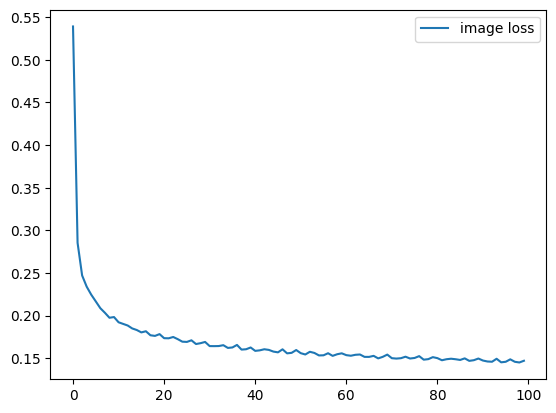

In [19]:
i_loss = np.load("ddim_i_loss_history.npy")
plt.plot(i_loss, label="image loss")
plt.legend()

In [20]:
model.network.load_weights("weights_ddim/model_epoch_380.weights.h5")

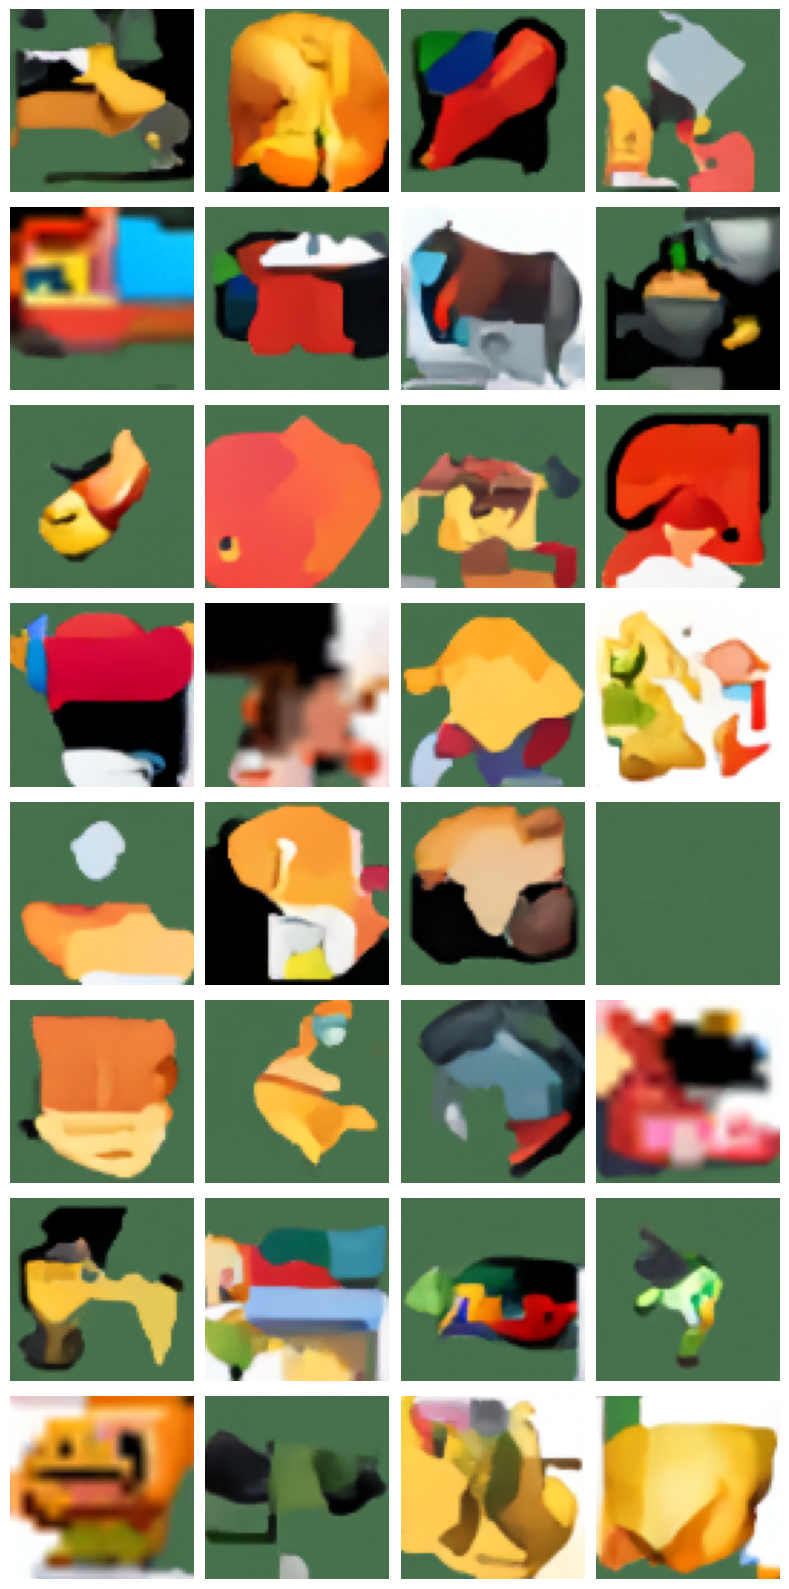

In [21]:
num_rows = 8
num_cols = 4
generated_images = model.generate(
    num_images=num_rows
    * num_cols,
    diffusion_steps=20,
)

plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
for row in range(num_rows):
    for col in range(num_cols):
        index = row * num_cols + col
        plt.subplot(num_rows, num_cols, index + 1)
        plt.imshow(generated_images[index])
        plt.axis("off")
plt.tight_layout()
plt.show()

### Are the results any good?

Meh, but these are my favourites!

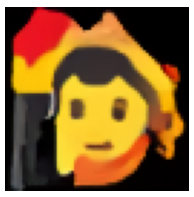 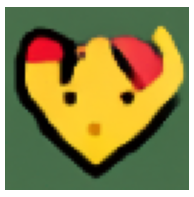 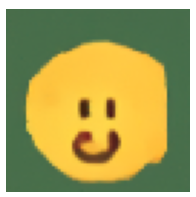 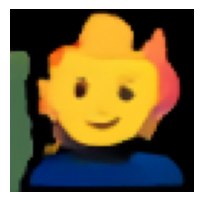

Assessing the results of generative model is not easy. Some examples of metrics include Inception Score (IS) and Fréchet Inception Distance (FID), but subjective evaluation from real people remain the most effective method.